In [1]:
%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/homebrew/Caskroom/miniforge/base/envs/CSE255/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


###  load image filenames

In [2]:
#use the following line when running on datahub
poverty_dir = '/Users/chenkang/Downloads/'
depth=8   #for KDTree

In [3]:
## load file list
image_dir=poverty_dir+'/anon_images'
files=[]
files+=glob(f'{image_dir}/*.npz')
len(files)

19669

In [4]:
!ls ../public_tables/

country_test_reduct.csv random_test_reduct.csv  train.csv


In [5]:
#load table entries
train_table='../public_tables/train.csv'
!ls -l $train_table

df=pd.read_csv(train_table,index_col=0)
df.index=df['filename']
df.shape

-rw-r--r--  1 chenkang  staff  786422 Jun  7 14:59 ../public_tables/train.csv


(11365, 6)

In [6]:
#List the number of rows for each country, countries 0-4 are missing - the are in the country_test set
from collections import Counter
C=Counter(df['country'])
[(k,C[k]) for k in sorted(C)]

[(5, 676),
 (6, 641),
 (7, 329),
 (8, 586),
 (9, 1381),
 (10, 374),
 (11, 575),
 (12, 428),
 (13, 1068),
 (14, 581),
 (15, 756),
 (16, 248),
 (17, 246),
 (18, 581),
 (19, 424),
 (20, 456),
 (21, 543),
 (22, 1472)]

## train color encoder

Creates a KDtree in color space

In [7]:
%%time
## Generate encoding tree
print(len(files))
train_size,tree=train_encoder(files,max_images=1024,tree_depth=12)

19669
used 500 images to train KDTree
KDTree training data shape= (25088000, 8)
CPU times: user 7.64 s, sys: 1.7 s, total: 9.34 s
Wall time: 10.4 s


In [8]:
# %%time
# ## Encode all data using encoding tree
# Enc_data=encoded_dataset(image_dir,df,tree,label_col='label')

In [9]:
# Enc_data.data.shape

In [10]:

# D=DataSplitter(Enc_data.data)

### Train and test

In [11]:
# set parameters for XGBoost
param['max_depth']=2
param['num_round']=10
param

{'max_depth': 2,
 'eta': 0.3,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': ['error', 'logloss'],
 'num_round': 10}

### Train on random split, urban and rural together

In [12]:
# %%time
# # train_selector=np.random.rand(df.shape[0]) > 0.7
# # Train=D.get_subset(train_selector)
# # Test=D.get_subset(~train_selector)

# train_selector = np.random.rand(df.shape[0]) < 0.7
# train_df = df[train_selector]
# # Train_augmented = encoded_dataset(image_dir,train_df,tree,label_col='label', augmentation=True).data
# Train = encoded_dataset(image_dir,train_df,tree,label_col='label').data
# # Train = np.concatenate((Train,Train_augmented),axis=0)
# np.random.shuffle(Train)

# test_df = df[~train_selector]
# Test = encoded_dataset(image_dir,test_df,tree,label_col='label').data

# param['num_round']=10
# log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
# param['num_round']=100
# log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

# styled_logs=[
#     {   'log':log10,
#         'style':['k:','k-'],
#         'label':'10 iterations',
#         'label_color':'k'
#     },
#     {   'log':log100,
#         'style':['r:','r-'],
#         'label':'100 iterations',
#         'label_color':'r'
#     }
# ]
# _mean,_std=plot_scores(styled_logs,title='All')

# pickle_file=f'data/DumpNoSplit.pk'
# Dump={'styled_logs':styled_logs,
#      'tree':tree,
#      'mean':_mean,
#      'std':_std}
# pkl.dump(Dump,open(pickle_file,'wb'))
# !ls -l $pickle_file

## Train on Urban only
Random split into train and test.

-rw-r--r--  1 chenkang  staff  3209038 Jun  8 13:00 data/DumpUrban.pk
CPU times: user 8min 57s, sys: 56.2 s, total: 9min 53s
Wall time: 5min 31s


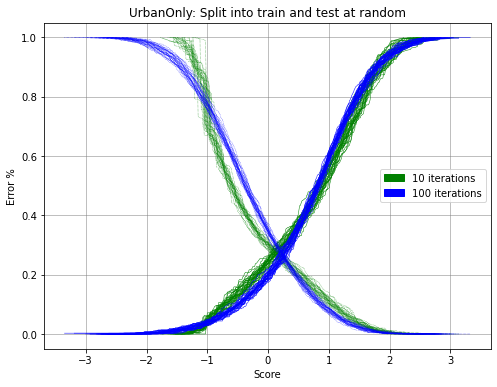

In [13]:
%%time
urban=True
area= 'Urban' if urban else 'Rural'
# selector=df['urban']==urban
# subData=D.get_subset(selector)
# subD=DataSplitter(subData)

# train_selector=np.random.rand(subData.shape[0]) > 0.7
# Train=subD.get_subset(train_selector)
# Test=subD.get_subset(~train_selector)

sub_df = df[df['urban']==urban]
train_selector = np.random.rand(sub_df.shape[0]) > 0.3
train_df = sub_df[train_selector]
Train = encoded_dataset(image_dir,train_df,tree,label_col='label', augmentation=True).data
# Train_augmented = encoded_dataset(image_dir,train_df,tree,label_col='label', augmentation=True).data
# Train = np.concatenate((Train,Train_augmented),axis=0)
test_df = sub_df[~train_selector]
Test = encoded_dataset(image_dir,test_df,tree,label_col='label').data

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['g:','g-'],
        'label':'10 iterations',
        'label_color':'g'
    },
    {   'log':log100,
        'style':['b:','b-'],
        'label':'100 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

## Train on Rural only
Random split into train and test.

-rw-r--r--  1 chenkang  staff  3451425 Jun  8 13:08 data/DumpRural.pk


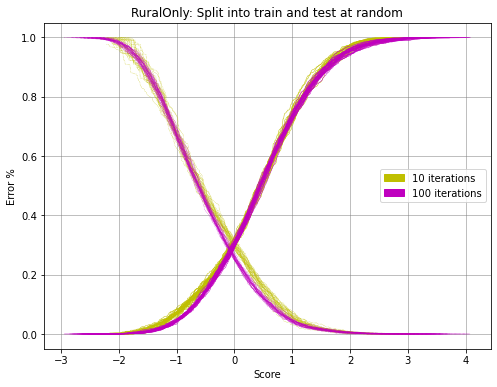

In [14]:
urban=False
area= 'Urban' if urban else 'Rural'
# selector=df['urban']==urban
# subData=D.get_subset(selector)
# subD=DataSplitter(subData)

# train_selector=np.random.rand(subData.shape[0]) > 0.7
# Train=subD.get_subset(train_selector)
# Test=subD.get_subset(~train_selector)

sub_df = df[df['urban']==urban]
train_selector = np.random.rand(sub_df.shape[0]) > 0.3
train_df = sub_df[train_selector]
Train = encoded_dataset(image_dir,train_df,tree,label_col='label', augmentation=True).data
# Train_augmented = encoded_dataset(image_dir,train_df,tree,label_col='label', augmentation=True).data
# Train = np.concatenate((Train,Train_augmented),axis=0)
test_df = sub_df[~train_selector]
Test = encoded_dataset(image_dir,test_df,tree,label_col='label').data

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['y:','y-'],
        'label':'10 iterations',
        'label_color':'y'
    },
    {   'log':log100,
        'style':['m:','m-'],
        'label':'100 iterations',
        'label_color':'m'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file